In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
import gym


### Room generating functions ###

def initialize_room(width=10, max_island_size=5, min_n_islands=1, max_n_islands=5):
    """
    Initialises the basic room shape.
    Room is represented by a np.array(shape=(width, width)), initially just with 0 for wall and 1 for floor.
    Start by marking walls around the edges of the square, then creates 'islands' of inaccessible areas.
    No dirt is created yet.
    """
    assert width > max_island_size

    # Initialize main room
    room = np.zeros([width, width], dtype=np.int8)

    # Create square to clean in center
    room[1:-1, 1:-1] = 1

    # Create random impassable 'islands'
    n_islands = np.random.randint(low=min_n_islands, high=max_n_islands)
    for island in range(n_islands):
        island_size = np.random.randint(low=1, high=max_island_size)
        island_x = np.random.randint(low=0-island_size + 1, high=width-1)
        island_y = np.random.randint(low=0-island_size + 1, high=width-1)

        for x_pos in range(island_x, island_x + island_size):
            for y_pos in range(island_y, island_y + island_size):
                if x_pos < 0:
                    x = 0
                elif x_pos >= width:
                    x = width - 1
                else:
                    x = x_pos
                if y_pos < 0:
                    y = 0
                elif y_pos >= width:
                    y = width - 1
                else:
                    y = y_pos

                room[x, y] = 0

    return room

def is_valid_room(room):
    """
    Takes in an initialised room of walls and floors, then returns True if every cell of the
    room is accessible, False otherwise.
    """
    target_sum = np.sum(room)
    visited = np.zeros(room.shape)

    # If there are only walls, room is invalid
    if target_sum == 0:
        return False

    first_cell = np.argwhere(room==1)[0]

    def explore(room, current_cell, depth, max_depth=100):
        if depth > max_depth: return
        if visited[current_cell[0], current_cell[1]] == 1: return
        visited[current_cell[0], current_cell[1]] = 1

        neighbours = [[current_cell[0] - 1, current_cell[1]] if current_cell[0] > 0 else None,
                      [current_cell[0] + 1, current_cell[1]] if current_cell[0] < room.shape[0] else None,
                      [current_cell[0], current_cell[1] - 1] if current_cell[1] > 0 else None,
                      [current_cell[0], current_cell[1] + 1] if current_cell[1] < room.shape[1] else None]
        neighbours = [neighbour for neighbour in neighbours if neighbour is not None]
        neighbours = [neighbour if room[neighbour[0], neighbour[1]] == 1 else None for neighbour in neighbours]
        neighbours = [neighbour for neighbour in neighbours if neighbour is not None]

        for neighbour in neighbours:
            explore(room, neighbour, depth + 1)

    explore(room, first_cell, depth=0)

    return np.sum(visited) == target_sum

def generate_room(width=10, max_island_size=5, min_n_islands=1, max_n_islands=5, seed=None):
    """
    Will generate a new room with given parameters.
    After 1 million attempts, program will throw an error, as it's likely the user has entered
    invalid parameters than cannot build a valid room.
    """
    if seed is not None:
        np.random.seed(seed)

    attempts = 1
    room = initialize_room(width, max_island_size, min_n_islands, max_n_islands)
    while not is_valid_room(room):
        assert attempts < 1e6, "1e6 generations attempted, issue with generation parameters."
        attempts += 1
        room = initialize_room(width, max_island_size, min_n_islands, max_n_islands)

    if seed is not None:
        reset_rng()

    return room


### Spawning functions ###

def spawn_robot(room, pos_x=None, pos_y=None, orientation=None, seed=None):
    """
    Spawns a robot into the room according to given coordinates, or
    randomly if none are given.
    """
    # If robot spawn position is given
    if pos_x is not None and pos_y is not None:
        assert room[pos_x, pos_y] in [-1, 1], "Invalid spawn position."
        if orientation is None:
            orientation = np.random.randint(low=1, high=5)
        room[pos_x, pos_y] += orientation
        return room

    # Else, random or seeded spawn
    if seed is not None:
        np.random.seed(seed)

    # Generate random spawn position and orientation
    room_size_x, room_size_y = room.shape[0], room.shape[1]
    pos_x, pos_y = np.random.randint(low=0, high=room_size_x), np.random.randint(low=0, high=room_size_y)
    while room[pos_x, pos_y] not in [-1, 1]:
        pos_x, pos_y = np.random.randint(low=0, high=room_size_x), np.random.randint(low=0, high=room_size_y)

    # An orientation of 1 is facing upward, then moving clockwise so 4 is nine o'clock
    orientation = np.random.randint(low=1, high=5) + 1  # +1 as it's spawning on floor, which has a value of 1
    room[pos_x, pos_y] = orientation

    if seed is not None:
        reset_rng()

    return room

def spawn_dirt(room, fraction=1, seed=None):
    """
    Creates dirt tiles in room.
    The fraction parameter denotes the approximate fraction of tiles to be made dirty.
    """
    if seed is not None:
        np.random.seed(seed)

    existing_dirt = (room < 0).astype(np.int8)
    dirt = np.random.uniform(size=room.shape) + existing_dirt
    dirt = 2 * (dirt > fraction).astype(np.int8) - 1

    if seed is not None:
        reset_rng()

    robot_pos = np.argwhere(abs(room) > 1)
    if len(robot_pos) == 0:
        return dirt * room
    else:
        dirty_room = dirt * room
        dirty_room[robot_pos[0][0], robot_pos[0][1]] = abs(dirty_room[robot_pos[0][0], robot_pos[0][1]])
        return dirty_room

def spawn_n_dirt(room, n=1, seed=None):
    """
    Spawns n number of dirty tiles in room. Will always create this many more dirty tiles.
    """
    clean_tile_indices = np.argwhere(room == 1)

    n_clean_tiles = len(clean_tile_indices)

    # If there are not clean tiles to make dirty, return the room
    if n_clean_tiles == 0:
        return room

    if n_clean_tiles < n:
        n = n_clean_tiles

    if seed is not None:
        np.random.seed(seed)

    chosen_indices = clean_tile_indices[np.random.choice(len(clean_tile_indices), size=n, replace=False)]
    room[chosen_indices[:, 0], chosen_indices[:, 1]] = -1

    if seed is not None:
        reset_rng()

    return room

def clean_room(room):
    "Returns a cleaned version of the room."
    dirt = 2 * (room > 0).astype(np.int8) - 1
    return dirt * room


### Visualisation functions ###

def construct_image(room):
    is_robot_in_room = len(np.argwhere(abs(room) > 1)) > 0

    # 0 for wall, 1 for clean floor, 2 for dirty floor, 3 for robot
    if is_robot_in_room:
        cmap = ListedColormap(['#2E282A', '#F3EFE0', '#A8664A','#80A1D4'])
    elif is_room_clean(room):
        cmap = ListedColormap(['#2E282A', '#F3EFE0'])
    else:
        cmap = ListedColormap(['#2E282A', '#F3EFE0', '#A8664A'])

    # Assume all is wall then build image
    image = np.zeros(shape=(room.shape))
    image[room > 0] = 1
    image[room < 0] = 2
    image[abs(room) > 1] = 3
    return image, cmap

def calculate_robot_arrow(room):
    # Draw arrow for robot orientation
    robot_position = np.argwhere(abs(room) > 1)[0]
    robot_orientation = abs(room[robot_position[0], robot_position[1]]) - 1

    # Draw a square to represent the robot
    orientation_map = {1: (0, 1), 2: (1, 0), 3: (0, -1), 4: (-1, 0)}
    dx, dy = orientation_map[robot_orientation]
    arrow = patches.FancyArrow(
        robot_position[1],
        robot_position[0],
        dx/4,
        dy/4,
        width=0.12,
        head_width=0.4,
        head_length=0.2,
        color='#FFFFFF',
    )
    return arrow

def display_room(room):
    """
    Displays a room using matplotlib imshow with an arrow indicating orientation of robot.
    """

    image, cmap = construct_image(room)

    # Create image plot
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=cmap, origin='lower')

    # If robot exists in the room
    if len(np.argwhere(abs(room) > 1)) > 0:
        # Get arrow which indicates the direction robot is facing
        arrow = calculate_robot_arrow(room)
        # Add the arrow to the plot
        ax.add_patch(arrow)

    plt.show()


### Logic functions ###

def is_room_clean(room):
    return -1 not in room


### RNG functions ###

def reset_rng():
    """
    Resets the NumPy random number generator with a new seed derived from the current time.
    This allows for unique seeding up to a 10th of a microsecond resolution within the 32-bit integer limit.
    """
    time_seed = np.random.seed(np.int64((time.time() * 1e7) % (2**32-1)))
    np.random.seed(time_seed)


### Robot movement functions ###

def get_robot_pos(room):
    robot_pos = np.argwhere(abs(room) > 1)
    if len(robot_pos) == 0:
        return None
    else:
        return robot_pos[0]

def robot_move_forward(room):
    """
    Move robot forward one cell.
    If against wall, robot remains in place.
    Returns updated room and flag indicating if move was successful.
    """
    assert get_robot_pos(room) is not None, "No robot in room, move not possible."
    robot_pos = get_robot_pos(room)
    robot_orientation = room[robot_pos[0], robot_pos[1]] - 1

    # Note that indices are rows, cols, so are [y, x] (not x, y)
    # Robot facing up
    if robot_orientation == 1:
        move = np.array([1, 0])
    # Facing right
    elif robot_orientation == 2:
        move = np.array([0, 1])
    # Facing down
    elif robot_orientation == 3:
        move = np.array([-1, 0])
    # Facing left
    elif robot_orientation == 4:
        move = np.array([0, -1])

    new_pos = robot_pos + move

    if room[new_pos[0], new_pos[1]] == 0:
        return room, False

    # Place robot in new position
    room[new_pos[0], new_pos[1]] = room[robot_pos[0], robot_pos[1]]

    # Tile behind robot is clean
    room[robot_pos[0], robot_pos[1]] = 1

    return room, True

def robot_move_backward(room):
    "Same as move forward, just reversed."
    assert get_robot_pos(room) is not None, "No robot in room, move not possible."
    robot_pos = get_robot_pos(room)
    robot_orientation = room[robot_pos[0], robot_pos[1]] - 1

    # Note that indices are rows, cols, so are [y, x] (not x, y)
    # Robot facing up
    if robot_orientation == 1:
        move = np.array([-1, 0])
    # Facing right
    elif robot_orientation == 2:
        move = np.array([0, -1])
    # Facing down
    elif robot_orientation == 3:
        move = np.array([1, 0])
    # Facing left
    elif robot_orientation == 4:
        move = np.array([0, 1])

    new_pos = robot_pos + move

    if room[new_pos[0], new_pos[1]] == 0:
        return room, False

    # Place robot in new position
    room[new_pos[0], new_pos[1]] = room[robot_pos[0], robot_pos[1]]

    # Tile behind robot is clean
    room[robot_pos[0], robot_pos[1]] = 1

    return room, True

def robot_turn_right(room):
    "Robot rotates 90 degrees clockwise."
    assert get_robot_pos(room) is not None, "No robot in room, move not possible."
    robot_pos = get_robot_pos(room)
    robot_orientation = room[robot_pos[0], robot_pos[1]] - 2  # -2 because -1 default, -1 again for mod 4

    new_orientation = ((robot_orientation + 1) % 4) + 2
    room[robot_pos[0], robot_pos[1]] = new_orientation
    return room, True

def robot_turn_left(room):
    "Robot rotates 90 degrees anti-clockwise."
    assert get_robot_pos(room) is not None, "No robot in room, move not possible."
    robot_pos = get_robot_pos(room)
    robot_orientation = room[robot_pos[0], robot_pos[1]] - 2  # -2 because -1 default, -1 again for mod 4

    new_orientation = ((robot_orientation - 1) % 4) + 2
    room[robot_pos[0], robot_pos[1]] = new_orientation
    return room, True

def robot_wait(room):
    "Robot doesn't perform any actions and just remains where it is."
    return room, True


# Gym environment class
class CleaningRobots:
    def __init__(self, config=None):
        # Environment configuration
        if config == None:
            self.config = self.default_config()
        else:
            self.config = config

        self.max_steps = self.config['max_steps']
        self.sparse_reward = self.config['sparse_reward']

        self.room = self.initialize_environment()

        # Action and observation spaces (6 in observation space is for number of channels we split space into)
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Box(low=-1, high=5, shape=(6, self.config['width'], self.config['width']), dtype=np.int8)

        # Create history for rendering video and calculating episode lengths
        self.history = []
        self.history.append(self.room.copy())


    def observe(self, decompose_channels=True):
        if decompose_channels:
            "Splits room up into several channels for an agent to learn from."
            accessible_channel = np.where((self.room != 0), 1, 0)                  # Channel containing acessible tiles
            dirt_channel = np.where((self.room == -1), 1, 0)                       # Channel containing location of dirt

            robot_orientation = np.max(self.room) - 2                              # 0 for up, 1 right, 2 down, 3 left
            robot_pos = np.argwhere(self.room == np.max(self.room))[0]             # Get robot position
            robot_pos_channels = np.zeros((4, *self.room.shape))                   # Create 4 channels for robot position
            robot_pos_channels[robot_orientation, robot_pos[0], robot_pos[1]] = 1  # Place position in corresponding channel and index

            return np.concatenate((np.stack((accessible_channel, dirt_channel)), robot_pos_channels), axis=0)
        else:
            return self.room.copy()

    def reset(self, seed=None):
        "Resets environment, generating a new room to clean according to config."
        self.config['seed'] = seed
        self.room = self.initialize_environment()
        self.history = []
        self.history.append(self.room.copy())
        return self.observe()

    def step(self, action):
        assert (not self.is_terminated()) and (not self.is_truncated()), "Environment is done."

        # Handle action first
        # Move forward
        if action == 0:
            self.room, action_success = robot_move_forward(self.room)

        # Move backward
        elif action == 1:
            self.room, action_success = robot_move_backward(self.room)

        # Turn right
        elif action == 2:
            self.room, action_success = robot_turn_right(self.room)

        # Turn left
        elif action == 3:
            self.room, action_success = robot_turn_left(self.room)

        # Wait
        elif action == 4:
            self.room, action_success = robot_wait(self.room)

        # Save new room to history
        self.history.append(self.room.copy())

        # Calculate reward
        reward = self.calculate_reward(action, action_success)

        # Placeholder
        info = {'step': len(self.history)}

        # Obs, reward, terminated, truncated, info
        return self.observe(), reward, self.is_terminated(), self.is_truncated() , info

    def render(self):
        "Plays video of current episode from start to now."
        fig, ax = plt.subplots()

        image_data, cmap = construct_image(self.history[0])
        img = ax.imshow(image_data, cmap=cmap, origin='lower')

        # Placeholder for the arrow patch
        arrow_patch = None

        def update(frame):
            nonlocal arrow_patch
            image_data, cmap = construct_image(self.history[frame])
            arrow_data = calculate_robot_arrow(self.history[frame])
            img.set_data(image_data)

            # Remove the previous arrow if it exists
            if arrow_patch is not None:
                arrow_patch.remove()

            # Add a new arrow patch
            arrow_patch = ax.add_patch(arrow_data)

            return [img, arrow_patch]

        ani = FuncAnimation(fig, update, frames=range(len(self.history)), interval=400, blit=True)
        plt.close()
        return ani

    def calculate_reward(self, action, action_success=True):
        """
        Sparse reward will give +1 reward if room is clean, also a small penalty for any move
        and a medium penalty for failing to perform the desired action, generally indicating collision.
        """
        assert self.config['sparse_reward'], 'Dense reward not implemented yet.'

        if self.config['sparse_reward']:
            # If an agent completes the largest possible room in this many steps, it's done a reasonable job.
            max_room_size = self.room.reshape(-1).shape[0]
            action_penalty_scale = 1 / (1 * (max_room_size * 2))

            # Penalty for any move, slightly larger penalty for moving backwards to discourage it
            if action in [0, 2, 3, 4]:
                action_penalty = -1 * action_penalty_scale
            elif action in [1]:
                action_penalty = -1.25 * action_penalty_scale

            # Fixed negative penalty for attempting an invalid action (colliding with an object)
            if action_success == False:
                action_penalty -= 0.1

            # If the room is clean
            if self.is_terminated():
                reward = 1.

            #  Worth experimenting with this. May lead to faster learning may not.
            #  elif self.is_truncated():
            #      reward = -1

            else:
                reward = 0.

            return reward + action_penalty

    def initialize_environment(self, attempts=0):
        """
        Builds an environment for the robot to clean.
        Initialises a room, then spawns the robot, then generates dirt according to the config.
        If initialisation fails (created done room for example) reinitialise, abandon after too many attempts.
        """
        self.room = generate_room(width=self.config['width'],
                                  max_island_size=self.config['max_island_size'],
                                  min_n_islands=self.config['min_n_islands'],
                                  max_n_islands=self.config['max_n_islands'],
                                  seed=self.config['seed'])

        self.room = spawn_robot(self.room,
                                seed=self.config['seed'])

        if self.config['n_dirt_generation']:
            self.room = spawn_n_dirt(self.room,
                                     n=self.config['n_dirt_tiles'],
                                     seed=self.config['seed'])
        else:
            self.room = spawn_dirt(self.room,
                               fraction=self.config['dirt_fraction'],
                               seed=self.config['seed'])

        # After 10,000 initialisation attempts, raise exception
        if attempts > 1e4:
            raise Exception("Max number of attempts to initialise environment exceeded.")

        if self.is_terminated():
            # If a room is created that is done, try again
            self.initialize_environment(attempts + 1)

        return self.room

    def default_config(self):
        """
        In case a config file isn't provided for the environment, these are the default settings.
        """
        config = {
            'width': 10,
            'max_island_size': 5,
            'min_n_islands': 1,
            'max_n_islands': 5,
            'dirt_fraction': 0.5,
            'n_dirt_generation': False,
            'n_dirt_tiles': 5,
            'seed': None,
            'max_steps': 1000,
            'sparse_reward': True,
        }
        return config

    def is_truncated(self):
        "Flag indicating environment has run for longer than max steps."
        return len(self.history) > self.max_steps

    def is_terminated(self):
        "Flag indicating room is clean."
        return -1 not in self.room

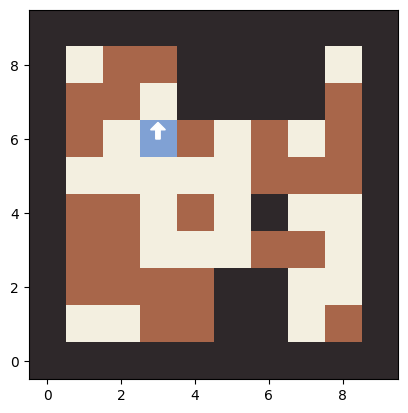

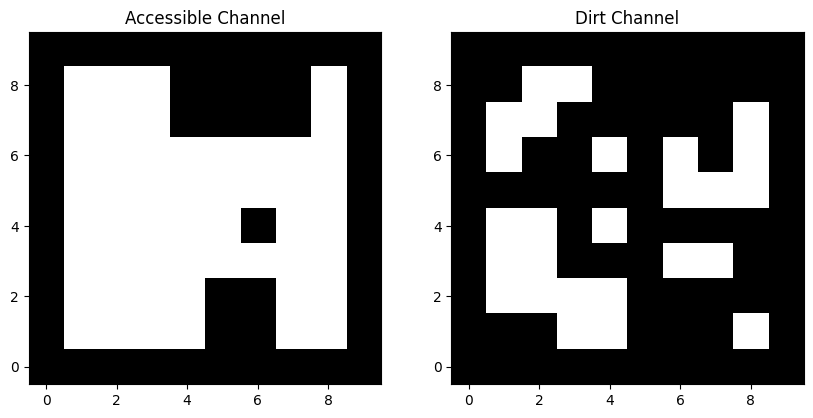

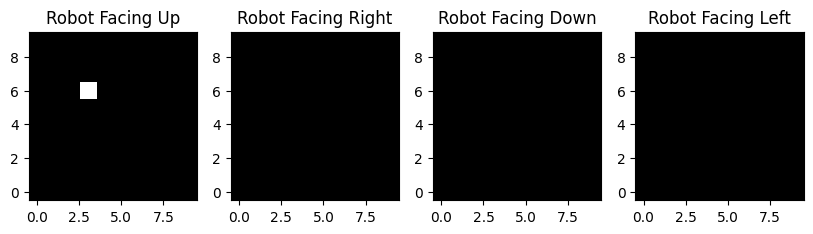

In [2]:
# Configuration for environment (optional)
env_config = {
    'width': 10,
    'max_island_size': 5,
    'min_n_islands': 1,
    'max_n_islands': 5,
    'dirt_fraction': 0.5,
    'n_dirt_generation': False,
    'n_dirt_tiles': 1,
    'seed': 42,
    'max_steps': 1000,
    'sparse_reward': True,
}

# Initialise environment
env = CleaningRobots(env_config)

# Display room
display_room(env.room)

obs = env.observe()

# Display first two channels (accessibility and dirt)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(obs[0], cmap='gray', origin='lower')
axes[0].set_title('Accessible Channel')
axes[1].imshow(obs[1], cmap='gray', origin='lower')
axes[1].set_title('Dirt Channel')
plt.show()

# Display last four channels (robot position and orientation)
fig, axes = plt.subplots(1, 4, figsize=(10, 2.2))
axes[0].imshow(obs[2], cmap='gray', origin='lower')
axes[0].set_title('Robot Facing Up')
axes[1].imshow(obs[3], cmap='gray', origin='lower')
axes[1].set_title('Robot Facing Right')
axes[2].imshow(obs[4], cmap='gray', origin='lower')
axes[2].set_title('Robot Facing Down')
axes[3].imshow(obs[5], cmap='gray', origin='lower')
axes[3].set_title('Robot Facing Left')
plt.show()

In [3]:
def build_room_permutations(room):
    permutations =  np.stack((
        room.copy(),                  # Original
        room.copy().T[::-1],          # Rotated right 90 degrees
        room.copy()[::-1].T[::-1].T,  # Rotated 180 degrees
        room.copy()[::-1].T,          # Rotated right 270 degrees

        room.copy().T[::-1].T,        # Flipped horizontally
        room.copy().T,                # Flipped horizontally and rotated right 90 degrees
        room.copy()[::-1],            # Flipped horizontally and rotated 180 degrees
        room.copy()[::-1].T[::-1]     # Flipped horizontally and rotated right 270 degrees
    ))

    # Get robot positions
    flat_indices = np.argmax(permutations.reshape(test_perms.shape[0], -1), axis=1)
    robot_positions = np.column_stack(np.unravel_index(flat_indices, permutations.shape[1:]))

    # Due to how we stored the robot positions, it's necessary we manually adjust the robots orientation
    rotations = np.array([0, 1, 2, 3, 0, 1, 2, 3])  # Indicating rotations of robot for each permutation
    permutations[np.arange(8), robot_positions[:, 0], robot_positions[:, 1]] = (
        (permutations[np.arange(8), robot_positions[:, 0], robot_positions[:, 1]] - 2 + rotations) % 4) + 2

    return permutations

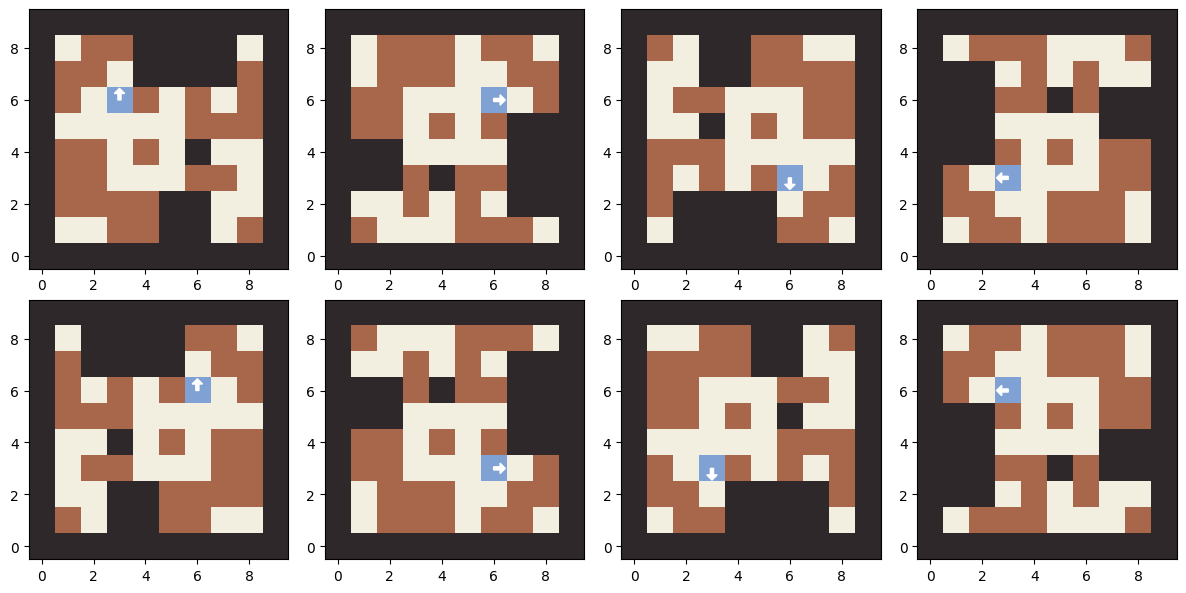

In [4]:
def display_room_permutations(room):
    "Displays the original room, and the 7 identical permutations of that room."
    room_list = [
        room.copy(),
        room.copy().T[::-1],
        room.copy()[::-1].T[::-1].T,
        room.copy()[::-1].T,

        room.copy().T[::-1].T,
        room.copy().T,
        room.copy()[::-1],
        room.copy()[::-1].T[::-1]
    ]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    for idx, room in enumerate(room_list):

        robot_position = np.argwhere(abs(room) > 1)[0]
        current_orientation = room[robot_position[0], robot_position[1]]
        new_orientation = (current_orientation + idx - 2) % 4 + 2
        room[robot_position[0], robot_position[1]] = new_orientation

        image, cmap = construct_image(room)

        axes.flatten()[idx].imshow(image, cmap=cmap, origin='lower')

        # If robot exists in the room
        if len(np.argwhere(abs(room) > 1)) > 0:
            # Get arrow which indicates the direction robot is facing
            arrow = calculate_robot_arrow(room)
            # Add the arrow to the plot
            axes.flatten()[idx].add_patch(arrow)

    plt.tight_layout()
    plt.show()

display_room_permutations(env.room)

In [5]:
# Configuration for environment (optional)
env_config = {
    'width': 10,
    'max_island_size': 5,
    'min_n_islands': 1,
    'max_n_islands': 5,
    'dirt_fraction': 0.5,
    'n_dirt_generation': True,
    'n_dirt_tiles': 1,
    'seed': 42,
    'max_steps': 1000,
    'sparse_reward': True,
}

# Initialise environment
env = CleaningRobots(env_config)

# Move in environment
env.step(2)
for _ in range(4):
    env.step(0)
env.step(2)
for _ in range(3):
    env.step(0)
env.step(2)
for _ in range(5):
    env.step(0)

# Display animation of episode
animation = env.render()
HTML(animation.to_jshtml())

In [6]:
class SeqVectorisedEnvWrapper:
    """
    Sequential environment wrapper for Gym environments.
    `env` is a reference to the environment class, not an instance of it.
    """
    def __init__(self, env, n_envs, env_config=None):
        self.n_envs = n_envs
        self.envs = [env(env_config) for _ in range(n_envs)]

        self.single_observation_space = self.envs[0].observation_space
        self.single_action_space = self.envs[0].action_space

    def reset(self, indices=None, seeds=None):
        """
        Resets environments according to indices [0, 3, 5] would reset the 0th 3rd and 5th environments.
        Returns observations from all environments, regardless of whether they've been reset or not for simplicity.
        """
        if indices is None:
            indices = range(self.n_envs)

        if seeds is not None:
            assert len(indices) == len(seeds), 'Seeds and indices lengths do not match.'

        for i, idx in enumerate(indices):
            seed = seeds[i] if seeds is not None else None
            _ = self.envs[idx].reset(seed=seed)

        return self.observe()

    def step(self, actions):
        "Perform a step in each environment instance sequentially."
        assert len(actions) == self.n_envs, "Incorrect number of actions given. Actions should be given as np.array or List."

        observations, rewards, terminateds, truncateds, infos = [], [], [], [], []

        # Sequentially performed in for loop
        for idx, env in enumerate(self.envs):
            obs, reward, terminated, truncated, info = env.step(actions[idx])
            observations.append(obs)
            rewards.append(reward)
            terminateds.append(terminated)
            truncateds.append(truncated)
            infos.append(info)

        return np.array(observations), np.array(rewards), np.array(terminateds), np.array(truncateds), infos

    def observe(self):
        return np.array([env.observe() for env in self.envs])

    def render(self, env_idx=0):
        return self.envs[env_idx].render()

In [7]:
class RandomAgent:
    def __init__(self):
        pass

    def set_envs(self, envs):
        "Sets vectorised environments for the agent."
        self.n_envs = envs.n_envs
        self.envs = envs

    def select_action(self, observations):
        """
        Action selection logic.
        Returns a 1D numpy array of actions.
        """
        actions = np.array([envs.single_action_space.sample() for _ in range(self.n_envs)])
        return actions

    def evaluate_policy(self, n_eval_episodes):
        """
        Evaluates the agents performance in a set of seeded environments.
        Returns the mean and standard deviation of the rewards.
        """
        complete_episode_rewards = []
        accumulated_episode_rewards = np.zeros([self.n_envs])
        observations = self.envs.reset(indices=[*range(self.n_envs)], seeds=[*range(self.n_envs)])
        n_completed_episodes = 0

        while n_completed_episodes < n_eval_episodes:
            actions = self.select_action(observations)
            observations, rewards, terminateds, truncateds, _ = self.envs.step(actions)
            dones = np.logical_or(terminateds, truncateds)
            accumulated_episode_rewards += rewards

            n_done_environments = np.sum(dones)

            if n_done_environments > 0:
                # Reset done environments
                done_episode_indices = np.argwhere(dones)[:, 0]
                new_episode_seeds = [*range(n_completed_episodes + self.n_envs, n_completed_episodes + self.n_envs + n_done_environments)]
                self.envs.reset(indices=done_episode_indices, seeds=new_episode_seeds)
                n_completed_episodes += n_done_environments

                # Log rewards from done episodes then reset
                completed_episode_rewards = accumulated_episode_rewards[done_episode_indices]
                for r in completed_episode_rewards:
                    complete_episode_rewards.append(r)
                accumulated_episode_rewards[done_episode_indices] = 0

        reward_mean = np.mean(complete_episode_rewards)
        reward_std = np.std(complete_episode_rewards)
        return reward_mean, reward_std


# Create 8 vectorised instances of the cleaning robots environments
envs = SeqVectorisedEnvWrapper(CleaningRobots, n_envs=8, env_config=env_config)

# Instantiate agent and set envs
random_agent = RandomAgent()
random_agent.set_envs(envs)

# Evaluate random agent performance
mean, std = random_agent.evaluate_policy(100)
print(f"Policy mean reward: {mean}, std: {std}")

Policy mean reward: -3.050337500000002, std: 3.9574231074929216


In [8]:
import torch
import torch.nn.functional as F
from torch import nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution configuration
        image_shape = (10, 10)
        kernel_size = 3
        stride = 1
        padding = 1

        # Inverse bottleneck expansion ratio
        expansion_ratio = 4

        # Separable convolution layers (depthwise and pointwise)
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise_expand = nn.Conv2d(in_channels, out_channels*expansion_ratio, kernel_size=1, bias=False)
        self.pointwise_contract = nn.Conv2d(out_channels*expansion_ratio, out_channels, kernel_size=1, bias=False)

#         # Layer norm
#         self.norm = nn.LayerNorm(normalized_shape=(in_channels, *image_shape))

        # Projection shortcut if in and out channels aren't equal
        if in_channels != out_channels:
            self.residual_pathway = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.residual_pathway = nn.Identity()

        # GELU activation
        self.activation = nn.ReLU()

    def forward(self, x):
        # Skip connection
        residual = self.residual_pathway(x)

        # Depthwise convolution
        x = self.depthwise_conv(x)
#         x = self.norm(x)

        # Expand dimensions
        x = self.pointwise_expand(x)
        x = self.activation(x)

        # Contract dimensions
        x = self.pointwise_contract(x)
        x = self.activation(x)

        return x + residual

In [9]:
class Network(nn.Module):
    def __init__(self, config=None):
        super().__init__()

        # Default config values if no config is provided
        n_filters  = 32 if config == None else config['n_filters']
        n_blocks   =  6 if config == None else config['n_blocks']
        n_actions  =  5 if config == None else config['n_actions']
        image_size = 10 if config == None else config['image_size']

        # Shape of convolutional output
        conv_output_shape = (n_filters, image_size, image_size)

        # Base block, then additional residual blocks
        blocks = [ResidualBlock(in_channels=6, out_channels=n_filters)]
        blocks.extend([ResidualBlock(n_filters, n_filters) for _ in range(n_blocks - 1)])

        # Combine all to form shared network base
        self.base = nn.Sequential(
            *blocks,
            nn.Flatten()
        )

        # Policy and value heads
        self.policy_head = nn.Linear(np.prod(conv_output_shape), n_actions)  # Returns logits
        self.value_head = nn.Linear(np.prod(conv_output_shape), 1)           # Returns value

    def forward(self, x):
        "Forward pass through base, policy and value heads"
        x = self.base(x)
        return self.policy_head(x), self.value_head(x)

In [10]:
# Configuration for network
network_config = {
    'n_filters': 32,   # Number of channels for separable convolution blocks
    'n_blocks': 6,     # Number of ConvNeXt residual blocks
    'n_actions': 5,    # Discrete action space size
    'image_size': 10,  # Height or width of square room
}

# Sample input, batch size of 2
input_tensor = torch.tensor(np.ones((2, 6, 10, 10)), dtype=torch.float32)

# Initialise model
network = Network(network_config)

print(f"Input shape: {input_tensor.shape}")
print(f"Output shapes: {network(input_tensor)[0].shape}, {network(input_tensor)[1].shape}")

total_params = sum(p.numel() for p in network.parameters())
print(f"Network parameters: {total_params}")

Input shape: torch.Size([2, 6, 10, 10])
Output shapes: torch.Size([2, 5]), torch.Size([2, 1])
Network parameters: 66716


In [11]:
### TrainTrack Logger Module ###
import os
import csv

class Logger:
    def __init__(self, logs_filename='logs'):
        # Use the current directory and create a 'logs' directory if it doesn't exist
        current_dir = os.getcwd()
        log_dir = os.path.join(current_dir, 'logs')
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        self.logs_path = os.path.join(log_dir, logs_filename + '.csv')

    def log(self, data: dict):
        "data: dict containing name and value of each logged variable"
        # Check if the logs file exists to determine whether a header needs to be written
        file_exists = os.path.isfile(self.logs_path)
        with open(self.logs_path, 'a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=data.keys())
            if not file_exists:
                writer.writeheader()
            writer.writerow(data)

    def delete_logs(self, verbose=True):
        # Check if the logs file exists
        if os.path.exists(self.logs_path):
            # Delete the file
            os.remove(self.logs_path)
            if verbose: print(f"Deleted log file at: {self.logs_path}")
        else:
            if verbose: print(f"No log file found at: {self.logs_path}")

In [12]:
import os
import time
from collections import deque

class PPOAgent:
    def __init__(self, config=None):
        self.config = config if config is not None else self.default_config()
        self.logger = None

    def set_envs(self, envs):
        "Sets vectorised environments for the agent."
        assert hasattr(envs, 'n_envs'), "This PPO agent requires use of a vectorised environment wrapper."
        self.envs = envs

    def train(self):
        "Trains the agent for a specified number of timesteps."
        assert hasattr(self, 'network'), "Call `set_network` method before trying to train model."

        # Pre-allocate memory on GPU
        buffer_states   = torch.zeros((self.config['n_rollout_steps'], self.config['n_envs']) + self.envs.single_observation_space.shape).to(self.config['device'])
        buffer_actions  = torch.zeros((self.config['n_rollout_steps'], self.config['n_envs'])).to(self.config['device'])
        buffer_rewards  = torch.zeros((self.config['n_rollout_steps'], self.config['n_envs'])).to(self.config['device'])
        buffer_dones    = torch.zeros((self.config['n_rollout_steps'], self.config['n_envs'])).to(self.config['device'])
        buffer_logprobs = torch.zeros((self.config['n_rollout_steps'], self.config['n_envs'])).to(self.config['device'])
        buffer_values   = torch.zeros((self.config['n_rollout_steps'], self.config['n_envs'])).to(self.config['device'])

        start_time = time.time()
        current_training_step = 0

        # Initial state and done flag
        states = torch.tensor(self.envs.reset(), dtype=torch.float32).to(self.config['device'])
        dones = torch.zeros(self.config['n_envs']).to(self.config['device'])

        ### Used to track episodic returns for logging per environment ###
        episodic_return = np.zeros(self.config['n_envs'])
        episodic_step_count = np.zeros(self.config['n_envs'])
        rewards_deque = deque([0.], maxlen=20)  # When an ep finishes, we save episodic return here for that episode
        episode_duration_deque = deque(maxlen=20)  # Number of steps required for completion also saved here

        for epoch in range(1, self.config['n_epochs'] + 1):

            # Will make a more comprehensive updating function at some point
            print(f"\rEpoch {epoch}/{self.config['n_epochs']}, mean reward: {np.mean(rewards_deque):.3f}", end="")

            # Anneal learning rate
            if self.config['anneal_lr']:
                fraction = 1.0 - ((epoch - 1.0) / self.config['n_epochs'])
                lr_current = fraction * self.config['learning_rate']
                self.optimizer.param_groups[0]['lr'] = lr_current

            # Rollouts
            for step in range(0, self.config['n_rollout_steps']):
                current_training_step += self.config['n_envs']

                buffer_states[step] = states
                buffer_dones[step]  = dones

                # Action selection during rollouts doesn't require gradient updates
                with torch.no_grad():
                    enc = self.network.base(states)                              # Get encoding from network base
                    logits = self.network.policy_head(enc)                       # and logits from policy head
                    dist = torch.distributions.Categorical(logits=logits)        # Create torch pdist from logits
                    actions = dist.sample()                                      # Stochastically sampled actions
                    buffer_actions[step] = actions
                    buffer_logprobs[step] = dist.log_prob(buffer_actions[step])  # Log probability of selecting these actions
                    buffer_values[step]   = network.value_head(enc).view(-1)     # Value from network value head

                states, rewards, terminateds, truncateds, infos = self.envs.step(actions.cpu().numpy())
                dones = np.logical_or(terminateds, truncateds)
                buffer_rewards[step] = torch.tensor(rewards, dtype=torch.float32).to(self.config['device'])


                # Update for logging
                episodic_return += rewards
                episodic_step_count += 1

                # If episode(s) done
                if True in dones:
                    for env_idx, done_flag in enumerate(dones):    # Could be vectorised
                        if done_flag:
                            rewards_deque.append(episodic_return[env_idx])
                            episode_duration_deque.append(episodic_step_count[env_idx])
                            episodic_return[env_idx], episodic_step_count[env_idx] = 0., 0.
                    n_completed_episodes = sum(dones)
                    done_episode_indices = np.argwhere(dones)[:, 0]
                    seeds = [self.config['seed'] for _ in range(n_completed_episodes)]
                    self.envs.reset(indices=done_episode_indices, seeds=seeds)
                    states = self.envs.observe()

                # As we may have just reset some environments, create states tensor here
                states = torch.tensor(states, dtype=torch.float32).to(self.config['device'])
                dones = torch.tensor(dones, dtype=torch.float32).to(self.config['device'])


            # Compute Generalized Advantage Estimation (GAE)
            with torch.no_grad():
                # Estimate the value of the next state using the current policy's value head.
                # This is used as a bootstrap for the last state in the sequence.
                enc = self.network.base(states)
                next_value = self.network.value_head(enc).view(-1)

                # Initialise the tensor for storing computed advantages with zeros
                advantages = torch.zeros_like(buffer_rewards).to(self.config['device'])

                # Variable to store the advantage estimate of the next state; used in the GAE computation.
                lastgaelam = 0

                # Iterate through each step in the rollout in reverse order for more efficient computation
                for t in reversed(range(self.config['n_rollout_steps'])):
                    # Determine if the current timestep is terminal, which we use as a mask for next state valeus
                    # This affects the calculation as terminal states should not bootstrap the value of the next state
                    if t == self.config['n_rollout_steps'] - 1:        # If at final timestep, use next_state value
                        next_non_terminal = 1.0 - buffer_dones[t]
                        next_values = next_value
                    else:
                        next_non_terminal = 1.0 - buffer_dones[t + 1]  # Else use the value we previous computed during rollouts
                        next_values = buffer_values[t + 1]

                    # Calculate the temporal difference error (delta) for the current timestep.
                    # This represents the difference between the reward received and the expected value, adjusted by the value of the next state.
                    delta = buffer_rewards[t] + self.config['gamma'] * next_values * next_non_terminal - buffer_values[t]

                    # Update the advantage estimate using the calculated delta, discounted by both gamma and lambda.
                    # This forms the GAE, which is a weighted sum of future deltas, where the weights decrease exponentially.
                    advantages[t] = lastgaelam = delta + self.config['gamma'] * self.config['gae_lambda'] * next_non_terminal * lastgaelam

                # The returns are the sum of the computed advantages and the value estimates.
                # These are used as the targets for updating the value function.
                returns = advantages + buffer_values

            # Tracking metrics
            clipfracs = []
            approx_kls = []

            # Minibatch update
            # Flatten batches b_ indicates a full batch, mb_ indicates a minibatch
            batch_states     = buffer_states.reshape((-1,) + self.envs.single_observation_space.shape)
            batch_actions    = buffer_actions.reshape((-1,) + self.envs.single_action_space.shape)
            batch_logprobs   = buffer_logprobs.reshape(-1)
            batch_advantages = advantages.reshape(-1)
            batch_returns    = returns.reshape(-1)
            batch_values     = buffer_values.reshape(-1)

            # Learning updates
            batch_indices = np.arange(self.config['batch_size'])
            for learning_update_idx in range(self.config['n_learning_updates_per_batch']):
                np.random.shuffle(batch_indices)
                for start in range(0, self.config['batch_size'], self.config['minibatch_size']):
                    end = start + self.config['minibatch_size']
                    mb_indices = batch_indices[start:end]

                    # Get logits and values from current network
                    # The logits and values we have stored in our buffer are now 'old', we use the new and old ratios to compute clipping values
                    # This is the key step in trust-region policy optimisation
                    new_logits, new_values = self.network(batch_states[mb_indices])  # Forward pass through network with mb states
                    new_values = new_values.view(-1)
                    dist = torch.distributions.Categorical(logits=new_logits)  # Build pdist from logits
                    new_logprobs = dist.log_prob(batch_actions[mb_indices])    # Logprob of choosing action in each distribution
                    entropies = dist.entropy()                                 # Action distribution entropy

                    logratio = new_logprobs - batch_logprobs[mb_indices]       # log(a/b) = log(a) - log(b)
                    ratio = logratio.exp()                                     # exp(log(a/b)) = a/b

                    # Logging metrics
                    with torch.no_grad():
                        approx_kls += [((ratio - 1) - logratio).mean()]  # Calculate approx KL divergence between policies http://joschu.net/blog/kl-approx.html
                        clipfracs  += [((ratio - 1.).abs() > self.config['clip_coef']).float().mean()]  # Number of triggered clips (more means policy being adjusted more)

                    # Advantage normalisation
                    mb_advantages = batch_advantages[mb_indices]
                    mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    # Clipped surrogate objective
                    loss_surrogate_unclipped = -mb_advantages * ratio
                    loss_surrogate_clipped   = -mb_advantages * torch.clip(ratio,                         # Input
                                                                           1 - self.config['clip_coef'],  # Min
                                                                           1 + self.config['clip_coef'])  # Max
                    # Final policy loss
                    loss_policy = torch.max(loss_surrogate_unclipped, loss_surrogate_clipped).mean()

                    # Value loss with clipping
                    loss_v_unclipped = (new_values - batch_returns[mb_indices]) ** 2  # MSE loss
                    value_clipped = batch_values[mb_indices] + torch.clip(new_values - batch_returns[mb_indices], # Input
                                                                          -self.config['clip_coef'],              # Min
                                                                          self.config['clip_coef'])               # Max

                    loss_v_clipped = (value_clipped - batch_returns[mb_indices]) ** 2  # MSE loss
                    loss_v_max = torch.max(loss_v_unclipped, loss_v_clipped)
                    loss_value = 0.5 * loss_v_max.mean()                               # Honestly I don't get this *0.5 convention. Autograd go brrr

                    # Entropy loss
                    loss_entropy = entropies.mean()

                    # Weighted losses
                    loss = loss_policy + \
                           self.config['value_loss_weight'] * loss_value + \
                           -self.config['entropy_loss_weight'] * loss_entropy

                    # Global gradient clipping
                    self.optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(self.network.parameters(), self.config['max_grad_norm'])
                    self.optimizer.step()

            # Logging stuff here
            steps_per_second = int(current_training_step / (time.time() - start_time))
            mean_clipfrac = np.mean([item.cpu().numpy() for item in clipfracs])
            mean_kl_div = np.mean([item.cpu().numpy() for item in approx_kls])

            y_pred, y_true = batch_values.cpu().numpy(), batch_returns.cpu().numpy()
            var_y = np.var(y_true)
            explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

            # Suggested log for cleaning robots env - cleaned room (if terminated then fail, if truncated then succeeded)
            # Also log mean gradient norm

            epoch_logs = {
                'mean_training_episode_reward': np.mean(rewards_deque),
                'training_episode_reward_var': np.var(rewards_deque),
                'mean_episode_duration': np.mean(episode_duration_deque),
                'policy_loss': loss_policy.item(),
                'value_loss': loss_value.item(),
                'entropy_loss': loss_entropy.item(),
                'mean_kl_div': mean_kl_div,
                'clipfrac': mean_clipfrac,
                'explained_variance': explained_var,
                'learning_rate': lr_current,
                'steps_per_second': steps_per_second,
            }

            self.log(epoch_logs)

    def log(self, logs_dict):
        "Logs training information to file which can optionally be saved to disk."
        # If logger object doesn't exist, create one
        if self.logger == None:
            self.logger = Logger(logs_filename=self.config['run_name'] + '-logs')
            self.logger.delete_logs(verbose=False)
        self.logger.log(logs_dict)

    def select_action(self, states, deterministic=False):
        """
        Returns an action based on the given observations.
        The deterministic flag controls whether the action selection should be deterministic (greedy) or stochastic.
        """
        # Convert states to tensor
        states_tensor = torch.tensor(states, dtype=torch.float32).to(self.config['device'])

        # Forward pass through the network
        enc = self.network.base(states_tensor)
        logits = self.network.policy_head(enc)

        # Deterministic action selection
        if deterministic:
            actions = torch.argmax(logits, axis=1).cpu().numpy()
        # Stochastic action selection
        else:
            actions = torch.distributions.Categorical(logits=logits).sample().detach().cpu().numpy()

        return actions

    def action_probability(self, states, return_logits=False):
        """
        Returns the probability distribution over actions for a given observation.
        The return logits flag allows the returning of logits rather than the probability distribution.
        """
        states_tensor = torch.tensor(states, dtype=torch.float32).to(self.config['device'])

        # Forward pass through the network
        enc = self.network.base(states_tensor)
        logits = self.network.policy_head(enc)

        # Return logits/probs
        if return_logits:
            return logits
        else:
            return torch.distributions.Categorical(logits=logits).probs.detach().cpu().numpy()

    def evaluate_policy(self, n_eval_episodes):
        """
        Evaluates the agents performance in a set of seeded environments.
        Returns the mean and standard deviation of the rewards.
        """
        complete_episode_rewards = []
        accumulated_episode_rewards = np.zeros(self.config['n_envs'])
        observations = self.envs.reset(indices=[*range(self.config['n_envs'])], seeds=[*range(self.config['n_envs'])])
        n_completed_episodes = 0

        while n_completed_episodes < n_eval_episodes:
            actions = self.select_action(observations, deterministic=True)
            observations, rewards, terminateds, truncateds, _ = self.envs.step(actions)
            dones = np.logical_or(terminateds, truncateds)
            accumulated_episode_rewards += rewards

            n_done_environments = np.sum(dones)

            if n_done_environments > 0:
                # Reset done environments
                done_episode_indices = np.argwhere(dones)[:, 0]
                new_episode_seeds = [*range(n_completed_episodes + self.config['n_envs'], n_completed_episodes + self.config['n_envs'] + n_done_environments)]
                self.envs.reset(indices=done_episode_indices, seeds=new_episode_seeds)
                n_completed_episodes += n_done_environments

                # Log rewards from done episodes then reset
                completed_episode_rewards = accumulated_episode_rewards[done_episode_indices]
                for r in completed_episode_rewards:
                    complete_episode_rewards.append(r)
                accumulated_episode_rewards[done_episode_indices] = 0

        reward_mean = np.mean(complete_episode_rewards)
        reward_std = np.std(complete_episode_rewards)
        return reward_mean, reward_std

    def set_network(self, network):
        "Sets user defined policy and value networks after validating network is valid."
        # Verify network is formatted correctly
        required_attributes = ['base', 'policy_head', 'value_head']
        for attr in required_attributes:
            assert hasattr(network, attr), f"Network is missing required property: {attr}"
        assert hasattr(network, 'forward'), "Network is missing the required forward method."

        # Set network
        self.network = network

        # Also set optimiser
        self.optimizer = torch.optim.AdamW(self.network.parameters(), lr=self.config['learning_rate'], eps=1e-5)

    def reset(self):
        "Reinitialises network parameters and resets environment(s)"
        if hasattr(self, 'network'):
            for layer in self.network.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
        if hasattr(self, 'envs'):
            self.envs.reset()

    def save(self, path=None):
        "Saves model and config to specified path."
        assert hasattr(self, 'network'), "Network not found."
        if path is None:
            directory = 'saved-models'
            if not os.path.exists(directory):
                os.makedirs(directory)
            timestamp = time.strftime("%Y%m%d-%H%M%S")
            filename = f"ppo-agent-{timestamp}.pt"
            path = os.path.join(directory, filename)

        save_dict = {
            'network_state_dict': self.network.state_dict(),
            'config': self.config
        }
        torch.save(save_dict, path)
        print(f"Model saved to {path}")

    def load(self, path):
        "Loads model and config from specified path."
        if not os.path.exists(path):
            raise FileNotFoundError(f"No model found at {path}")

        checkpoint = torch.load(path)
        self.network.load_state_dict(checkpoint['network_state_dict'])
        self.config = checkpoint['config']
        print(f"Model loaded from {path}")

    def default_config(self):
        config = {
            # Experiment parameters
            'run_name': 'cleaning-robots-experiment-1',                # Experiment name
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',  # Device neural networks will run on
            'create_logs': True,                                       # Will dump logs to disk if True

            # Training parameters
            'n_envs': 8,                        # Number of vectorised environments
            'training_steps': 100000,           # Number of training steps experiment is carried out for
            'n_rollout_steps': 64,              # Number of steps performed in each environment to gather training data
            'n_minibatches': 4,                 # How many mini batches to split each training batch into
            'n_learning_updates_per_batch': 5,  # Number of times each batch is reused for learning, by dividing into minibatches and updating network params

            # PPO parameters
            'learning_rate': 2.5e-4,      # Adam learning rate
            'anneal_lr': True,            # Whether or not to linearly anneal learning rate
            'gamma': 0.99,                # Discount factor
            'clip_coef': 0.1,             # Clipping coefficient
            'gae_lambda': 0.95,           # Lambda value used in GAE
            'value_loss_weight': 0.5,     # Weight of value loss compared to policy loss
            'entropy_loss_weight': 0.01,  # Weight of entropy loss
            'max_grad_norm': 0.5,         # Global gradient clipping max norm
        }

        config['batch_size']     = config['n_envs'] * config['n_rollout_steps']
        config['minibatch_size'] = config['batch_size'] // config['n_minibatches']
        config['n_epochs']       = config['training_steps'] // config['batch_size']

        return config

In [13]:
env_config = {
    'width': 10,                  # Room width *changing will require a lot of reconfiguring*
    'max_island_size': 5,         # Max size of islands that spawn in room
    'min_n_islands': 1,           # Min number of islands that will spawn in room
    'max_n_islands': 5,           # Max number of islands that will spawn in room
    'dirt_fraction': 0.5,         # Proportion of room to be made dirty in case of non-n-dirt-gen
    'n_dirt_generation': True,    # True will spawn n-number of dirty tiles in room
    'n_dirt_tiles': 1,            # Number of tiles to be made dirty in cause n-dirt-gen is True
    'seed': None,                 # Random seed for environments
    'max_steps': 50,            # Max number of steps before environment truncates
    'sparse_reward': True,        # Type of reward function
}

network_config = {
    'n_filters': 32,              # Number of separable conv filters used in network
    'n_blocks': 6,                # Number of stacked blocks
    'n_actions': 5,               # Policy network output size
    'image_size': 10,             # Room size
}

ppo_config = {
    # Experiment parameters
    'run_name': 'cleaning-robots-experiment-1',                # Experiment name
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',  # Device neural networks will run on
    'create_logs': True,                                       # Will dump logs to disk if True

    # Training parameters
    'n_envs': 32,                        # Number of vectorised environments
    'training_steps': 1000000,           # Number of training steps experiment is carried out for
    'n_rollout_steps': 32,              # Number of steps performed in each environment to gather training data
    'n_minibatches': 8,                 # How many mini batches to split each training batch into
    'n_learning_updates_per_batch': 3,  # Number of times each batch is reused for learning, by dividing into minibatches and updating network params

    # PPO parameters
    'learning_rate': 5e-4,      # Adam learning rate
    'anneal_lr': True,            # Whether or not to linearly anneal learning rate
    'gamma': 0.99,                # Discount factor
    'clip_coef': 0.1,             # Clipping coefficient
    'gae_lambda': 0.95,           # Lambda value used in GAE
    'value_loss_weight': 0.5,     # Weight of value loss compared to policy loss
    'entropy_loss_weight': 0.05,  # Weight of entropy loss
    'max_grad_norm': 0.5,         # Global gradient clipping max norm
    'seed': None,
}

ppo_config['batch_size']     = ppo_config['n_envs'] * ppo_config['n_rollout_steps']
ppo_config['minibatch_size'] = ppo_config['batch_size'] // ppo_config['n_minibatches']
ppo_config['n_epochs']       = ppo_config['training_steps'] // ppo_config['batch_size']


print(f"Batch size: {ppo_config['batch_size']}")
print(f"Minibatch size: {ppo_config['minibatch_size']}")

def validate_ppo_config(ppo_config):
    "Catches any potential issues with user-defined config"
    assert type(ppo_config['batch_size']) == int, "Batch size must be integer."
    assert ppo_config['batch_size'] % ppo_config['n_minibatches'] == 0, "Batch size must be divisible by minibatch size."
    print("\nConfig file validated.\n")

validate_ppo_config(ppo_config)

Batch size: 1024
Minibatch size: 128

Config file validated.



In [14]:
envs = SeqVectorisedEnvWrapper(CleaningRobots, n_envs=ppo_config['n_envs'], env_config=env_config)
network = Network(network_config).to(ppo_config['device'])
agent = PPOAgent(ppo_config)

agent.set_envs(envs)
agent.set_network(network)

agent.train()

Epoch 976/976, mean reward: 0.929

In [15]:
# Configuration for environment
env_config = {
    'width': 10,
    'max_island_size': 5,
    'min_n_islands': 1,
    'max_n_islands': 5,
    'dirt_fraction': 0.5,
    'n_dirt_generation': True,
    'n_dirt_tiles': 1,
    'seed': 42,
    'max_steps': 50,
    'sparse_reward': True,
}

# Initialise environment
envs = SeqVectorisedEnvWrapper(CleaningRobots, n_envs=1, env_config=env_config)
done = False

while not done:
    actions = agent.select_action(envs.observe(), deterministic=True)
    states, rewards, terminateds, truncateds, infos = envs.step(actions)
    done = True in np.logical_or(terminateds, truncateds)

print('done')


# Display animation of episode
animation = envs.render()
HTML(animation.to_jshtml())

done


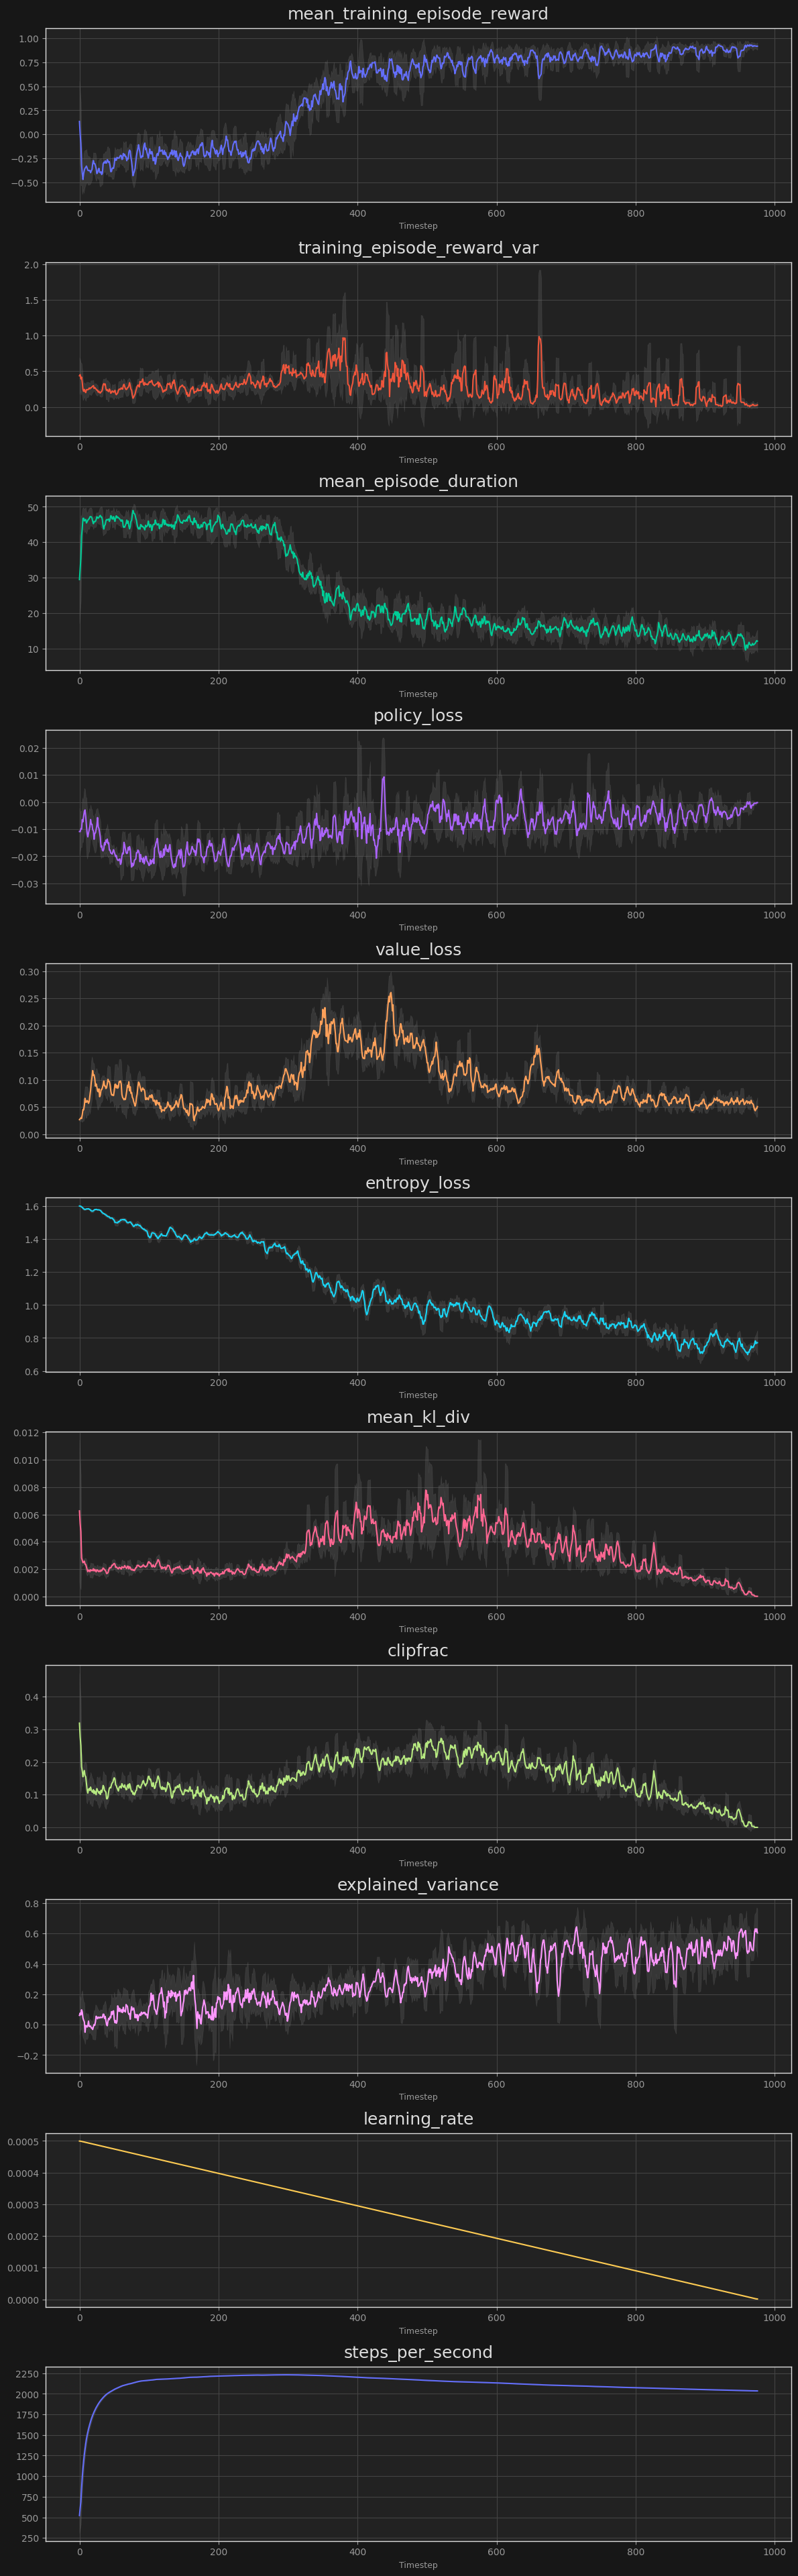

In [16]:
### Plotting Module ###
import numpy as np
import pandas as pd
import csv
import os
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt


# Settings
refresh_duration = 60      # How often to update plots (seconds)
theme            = 'dark'  # Dark theme or light theme
logs_filename    = 'cleaning-robots-experiment-1-logs.csv'


# Check logs file exists
current_dir = os.getcwd()
log_dir = os.path.join(current_dir, 'logs')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
logs_path = os.path.join(log_dir, logs_filename)
if not os.path.exists(logs_path):
    print(f"Error: The file '{logs_path}' was not found.\n")

    # Check for other files in working folder to help find logs
    file_found = False
    print("Listing all folders and files in current directory:")
    for dirname, dirs, filenames in os.walk(current_dir):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            file_found = True
    if not file_found:
        print("No files were found in the working directory.")
    raise FileNotFoundError(f"The logs file '{logs_path}' was not found.")

# Custom matplotlib styling
plt.style.use('ggplot')
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
plt.rcParams['axes.prop_cycle']  = plt.cycler(color=colors)
if theme == 'dark':
    plt.rcParams['figure.facecolor'] = '#171717'  # Figure background
    plt.rcParams['axes.facecolor']   = '#222222'  # Plot background
    plt.rcParams['text.color']       = '#DDDDDD'  # Title
    plt.rcParams['axes.labelcolor']  = '#999999'  # Axes label colours
    plt.rcParams['xtick.color']      = '#999999'  # X axis ticks
    plt.rcParams['ytick.color']      = '#999999'  # Y axis ticks
    plt.rcParams['grid.color']       = '#444444'  # Grid color, for subtlety against the dark background
    plt.rcParams['axes.edgecolor']   = '#DDDDDD'  # Color of the axes spines (the border of the plot)
    plt.rcParams['axes.titlesize']   = 18
    plt.rcParams['axes.labelsize']   = 9

def plot_data(df, window=5, plot_raw_points=False):
    def dynamic_wma(x):
        "Calculates weighted moving average for a set of points."
        actual_window = len(x)
        weights = np.ones(actual_window)          # Equal weight for each point (default)
        dynamic_weights = weights / sum(weights)  # Make weights sum to 1
        return np.sum(dynamic_weights * x)

    # Columns to plot
    cols = df.columns
    exclude_cols = ['timestep']  # Logs columns to exclude from plotting
    plot_cols = [col for col in cols if col not in exclude_cols]
    plot_height = 3.5

    plt.figure(figsize=(12, plot_height * len(plot_cols)))  # Adjust the figure size as necessary

    for idx, col in enumerate(plot_cols):
        # Feature to plot
        series = df[col]

        # Calculate trend line and variance for shaded region
        trend_line = series.rolling(window=window, center=True, min_periods=1).apply(dynamic_wma, raw=True)
        variance = series.rolling(window=window, center=True, min_periods=1).std()

        # Subplot for each series
        plt.subplot(len(plot_cols), 1, idx + 1)
        # Shaded region for variance
        plt.fill_between(series.index, trend_line - variance, trend_line + variance, color='#666666', alpha=0.3, label=f'{col} Variance')
        # Trend line
        plt.plot(series.index, trend_line, label=f'{col} Trend Line', color=colors[idx % len(colors)])
        # Add original raw points back in if desired
        if plot_raw_points:
            plt.scatter(series.index, series, alpha=0.5, s=6, label=f'{col} Original', color=colors[idx % len(colors)])

        plt.xlabel('Timestep', loc='center')
        plt.title(f'{col}', y=1.02)

    plt.tight_layout()
    plt.show()

df = pd.read_csv(logs_path)
clear_output(wait=True)
plot_data(df, plot_raw_points=False)